In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import re
import string
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, roc_auc_score,confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, KFold, learning_curve
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import learning_curve
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter


!python -m spacy download el_core_news_sm
import spacy

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.6/12.6 MB 37.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('el_core_news_sm')
/kaggle/input/ys19-2023-assignment-1/sample_submission.csv
/kaggle/input/ys19-2023-assignment-1/test_set.csv
/kaggle/input/ys19-2023-assignment-1/valid_set.csv
/kaggle/input/ys19-2023-assignment-1/train_set.csv


In [2]:
df = pd.read_csv("../input/ys19-2023-assignment-1/train_set.csv")
df_valid_csv = pd.read_csv("../input/ys19-2023-assignment-1/valid_set.csv")
df_test_csv = pd.read_csv("../input/ys19-2023-assignment-1/test_set.csv")

nlp = spacy.load("el_core_news_sm")
line_vectors = []
special_characters = "!@#$%^&*()-_+[]{}|;:'\"<>,.?/~`«»"
extra_stopwords = ['ότι', 'οτι', 'ένα', 'ενα', 'δύο', 'δυο', 'ε', 'σε', 'σου', 'πιο', 'όπως', 'οπως', 'άλλος', 'ως', 'ας', 'έτσι', 'αυτός', 'ένας', 'γιατί', 'γιατι', 'μου', 'κλπ', 'επί', 'όταν', 'είμαι', 'ειμαι', 'είναι', ' ', '  ', '   ', '    ', 'έχω', 'εχω', 'ενώ', 'εγώ', 'τώρα', 'εγω', 'ή', 'σαν', 'σε ο', 'από', 'όπως']

# Remove URLs, mentions, special characters and lowercasing
def clean_tweet(line):
    line = re.sub(r'http\S+', '', line)
    line = re.sub(r'@[A-Za-z0-9]+', '', line) 
    line = line.lower()
    for char in special_characters:
        line = line.replace(char, ' ')
    return line

# Tokenization and lemmatization
def clean_word_vector(line):
    filtered_vector = []
    text = nlp(line)
    for token in text:
        token = token.lemma_
        if token not in stopwords.words('greek') and token not in extra_stopwords:
            filtered_vector.append(token)
    return filtered_vector


# Preprocess every line and generate word vector
for index, row in df.iterrows():  #for each line
    line = clean_tweet(row["Text"])
    line_vectors.append(clean_word_vector(line))
    
line_vectors_valid = []
for index, row in df_valid_csv.iterrows():  #for each line
    line_valid = clean_tweet(row["Text"])
    line_vectors_valid.append(clean_word_vector(line_valid))
    
line_vectors_test_csv = []
for index, row in df_test_csv.iterrows():  #for each line
    line_valid = clean_tweet(row["Text"])
    line_vectors_test_csv.append(clean_word_vector(line_valid))

In [3]:
# ROC Curve plot function
def plot_roc_curve(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    
    # Prediction
    y_pred_proba = model.predict_proba(X_test)
    plt.figure(figsize=(10, 5))

    for i in range(len(model.classes_)):
        fpr, tpr, _ = roc_curve((y_test == model.classes_[i]).astype(int), y_pred_proba[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'Class {model.classes_[i]} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve for each class')
    plt.legend(loc="lower right")
    plt.show()
    
# Learning Curve plot function
def plot_learning_curve(model, X, y):
    train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=5)

    # Calculate mean and standard deviation for training set scores
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)

    # Calculate mean and standard deviation for test set scores
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot Learning Curve
    plt.figure(figsize=(10, 5))
    plt.title("Learning Curve")
    plt.xlabel("Training Examples")
    plt.ylabel("Score")

    # Plot training set scores
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training Score")
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")

    # Plot test set scores
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation Score")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")

    plt.legend(loc="best")
    plt.show()
    
# Confusion Matrix plot function    
def plot_confusion_matrix(model, X, y):
    model.fit(X, y)
    y_pred = model.predict(X)
    
    # Confusion Matrix
    conf_matrix = confusion_matrix(y, y_pred)

    # Plot Confusion Matrix using Seaborn
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=model.classes_, yticklabels=model.classes_)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

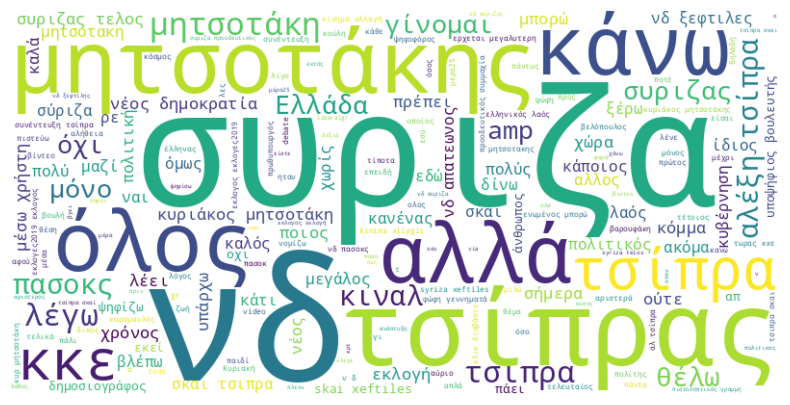

In [4]:
# Create a WordCloud 
text_for_wordcloud = ' '.join([' '.join(line) for line in line_vectors])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_for_wordcloud)

# Display the WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [5]:
# Count the frequency of each token
flat_word_vectors = [token for line in line_vectors for token in line]
token_frequency = Counter(flat_word_vectors)

# Display the 10 most common tokens with their frequencies
for token, frequency in token_frequency.most_common(10):
    print(f"{token}: {frequency} times")

νδ: 8156 times
τσίπρα: 5378 times
μητσοτάκη: 4099 times
συριζα: 3864 times
μητσοτάκης: 3802 times
κκε: 3514 times
συριζας: 3099 times
τσίπρας: 2690 times
τσιπρα: 2514 times
2019: 2496 times


In [6]:
# Train-Test split
X_train, X_test, y_train, y_test = train_test_split(line_vectors, df["Sentiment"], test_size=0.2, random_state=42)

# TF-IDF vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform([' '.join(line) for line in X_train])
X_test_tfidf = tfidf_vectorizer.transform([' '.join(line) for line in X_test])

In [7]:
y_valid = df_valid_csv["Sentiment"]
X_valid_tfidf = tfidf_vectorizer.transform([' '.join(line) for line in line_vectors_valid])

In [8]:
X_test_csv_tfidf = tfidf_vectorizer.transform([' '.join(line) for line in line_vectors_test_csv])

In [9]:
# Logistic Regression model
model = LogisticRegression(solver='saga')

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],    # Regularization parameter
    'max_iter': [500, 1000, 5000]           # Maximum number of iterations
}

In [10]:
# Create GridSearchCV and find best parameters
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_tfidf, y_train)
best_params = grid_search.best_params_
print("Best Parameters:", best_params)
best_model = grid_search.best_estimator_

# Prediction and find the accuracy
y_pred = best_model.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.10f}")
print("Classification Report:\n", classification_report(y_test, y_pred))

Best Parameters: {'C': 0.01, 'max_iter': 1000}
Accuracy: 0.3761943762
Classification Report:
               precision    recall  f1-score   support

    NEGATIVE       0.37      0.48      0.42      2447
     NEUTRAL       0.37      0.27      0.31      2450
    POSITIVE       0.39      0.38      0.39      2429

    accuracy                           0.38      7326
   macro avg       0.38      0.38      0.37      7326
weighted avg       0.38      0.38      0.37      7326



In [11]:
# Valid dataset
y_valid_pred = best_model.predict(X_valid_tfidf)

# Prediction and find the accuracy
accuracy = accuracy_score(y_valid, y_valid_pred)
print(f"Accuracy: {accuracy:.10f}")
print("Classification Report:\n", classification_report(y_valid, y_valid_pred))

Accuracy: 0.3969801223
Classification Report:
               precision    recall  f1-score   support

    NEGATIVE       0.39      0.50      0.44      1744
     NEUTRAL       0.39      0.29      0.33      1744
    POSITIVE       0.41      0.41      0.41      1744

    accuracy                           0.40      5232
   macro avg       0.40      0.40      0.39      5232
weighted avg       0.40      0.40      0.39      5232



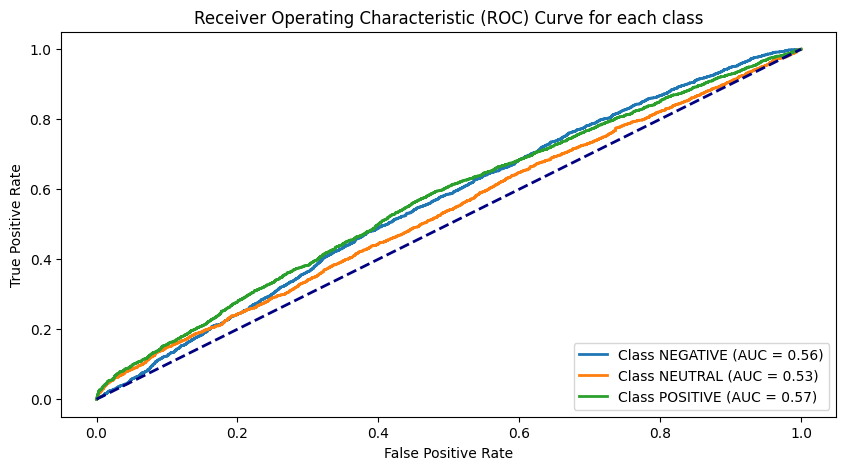

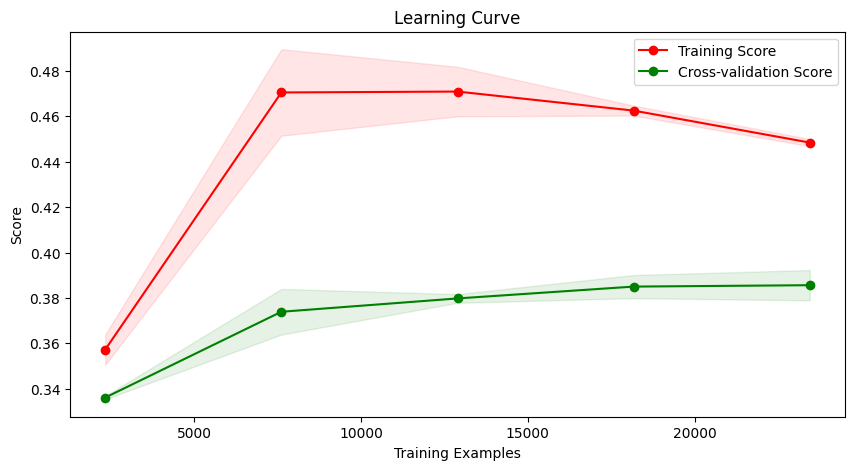

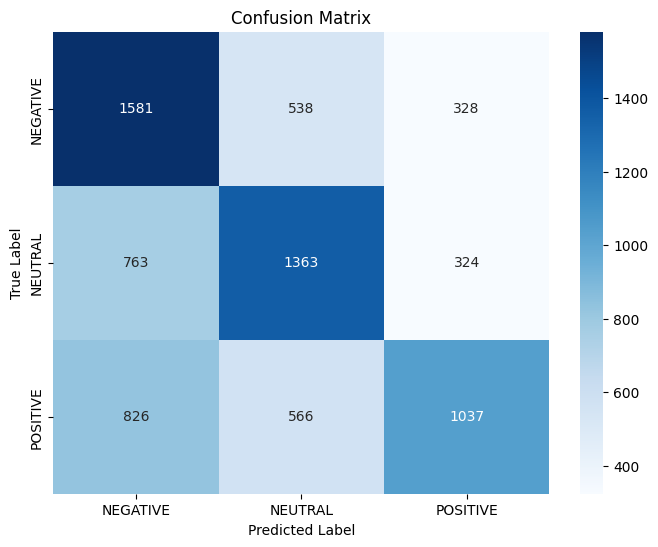

In [12]:
# Plot ROC Curve plot
plot_roc_curve(best_model, X_train_tfidf, X_test_tfidf, y_train, y_test)

# Learning Curve plot
plot_learning_curve(best_model, X_train_tfidf, y_train)

# Confusion Matrix plot
plot_confusion_matrix(best_model, X_test_tfidf, y_test)

In [13]:
model = LogisticRegression(max_iter = 5000)
# TruncatedSVD for dimension reduction
svd = TruncatedSVD(n_components=1000)
X_train_svd = svd.fit_transform(X_train_tfidf)
X_test_svd = svd.transform(X_test_tfidf)

# Create GridSearchCV and find best parameters
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_svd, y_train)
best_params = grid_search.best_params_
print("Best Parameters:", best_params)
best_model = grid_search.best_estimator_

# Prediction and find the accuracy
y_pred = best_model.predict(X_test_svd)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.10f}")
print("Classification Report:\n", classification_report(y_test, y_pred))

Best Parameters: {'C': 0.001, 'max_iter': 500}
Accuracy: 0.3787878788
Classification Report:
               precision    recall  f1-score   support

    NEGATIVE       0.38      0.44      0.41      2447
     NEUTRAL       0.38      0.21      0.27      2450
    POSITIVE       0.38      0.49      0.43      2429

    accuracy                           0.38      7326
   macro avg       0.38      0.38      0.37      7326
weighted avg       0.38      0.38      0.37      7326



In [14]:
# Valid dataset
X_valid_svd = svd.transform(X_valid_tfidf)

# Prediction and find the accuracy
y_valid_pred = best_model.predict(X_valid_svd)
accuracy = accuracy_score(y_valid, y_valid_pred)
print(f"Accuracy: {accuracy:.10f}")
print("Classification Report:\n", classification_report(y_valid, y_valid_pred))

Accuracy: 0.3960244648
Classification Report:
               precision    recall  f1-score   support

    NEGATIVE       0.40      0.46      0.43      1744
     NEUTRAL       0.41      0.23      0.29      1744
    POSITIVE       0.39      0.50      0.44      1744

    accuracy                           0.40      5232
   macro avg       0.40      0.40      0.39      5232
weighted avg       0.40      0.40      0.39      5232



In [15]:
# test_set.csv
X_test_csv_svd = svd.transform(X_test_csv_tfidf)

# Prediction and find the accuracy
y_test_csv_pred = best_model.predict(X_test_csv_svd)

# # Make the csv
# df_pred = pd.DataFrame({'Predicted': y_test_csv_pred})

df_id = pd.DataFrame({'Id': df_test_csv['New_ID']})
df_pred = pd.concat([df_id, pd.DataFrame({'Predicted': y_test_csv_pred})], axis=1)

csv_file_name = 'submission.csv'
df_pred.to_csv(csv_file_name, index=False)

# Print the DataFrame
df_submission = pd.read_csv('submission.csv')
print(df_submission)

          Id Predicted
0          1  POSITIVE
1          2  POSITIVE
2          3   NEUTRAL
3          4   NEUTRAL
4          5   NEUTRAL
...      ...       ...
10465  10466  NEGATIVE
10466  10467  NEGATIVE
10467  10468  POSITIVE
10468  10469  POSITIVE
10469  10470  NEGATIVE

[10470 rows x 2 columns]


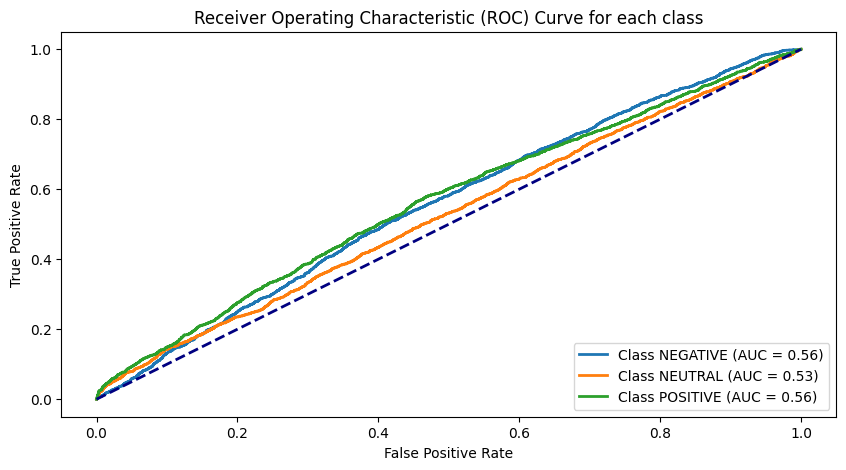

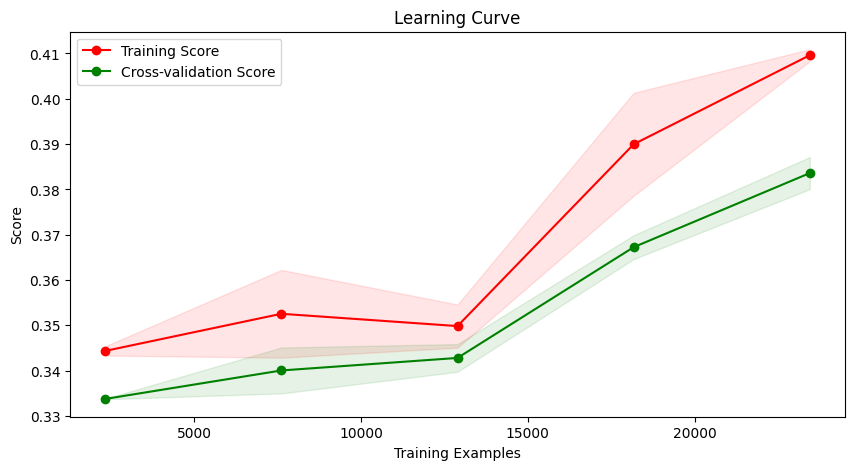

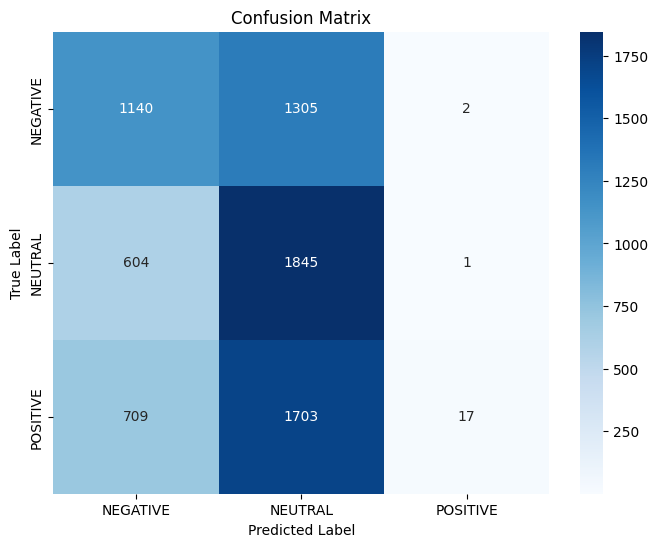

In [16]:
# Plot ROC Curve plot
plot_roc_curve(best_model, X_train_svd, X_test_svd, y_train, y_test)

# Learning Curve plot
plot_learning_curve(best_model, X_train_svd, y_train)

# Confusion Matrix plot
plot_confusion_matrix(best_model, X_test_svd, y_test)

[    0     1     2 ... 36626 36627 36628] [    4     6     7 ... 36617 36624 36629]
Accuracy: 0.3817908818
Classification Report:
               precision    recall  f1-score   support

    NEGATIVE       0.37      0.38      0.38      2447
     NEUTRAL       0.38      0.37      0.38      2450
    POSITIVE       0.39      0.39      0.39      2429

    accuracy                           0.38      7326
   macro avg       0.38      0.38      0.38      7326
weighted avg       0.38      0.38      0.38      7326



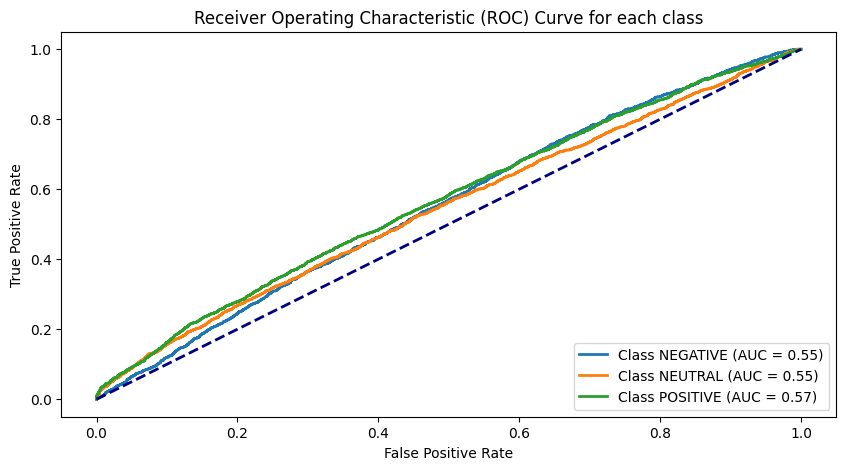

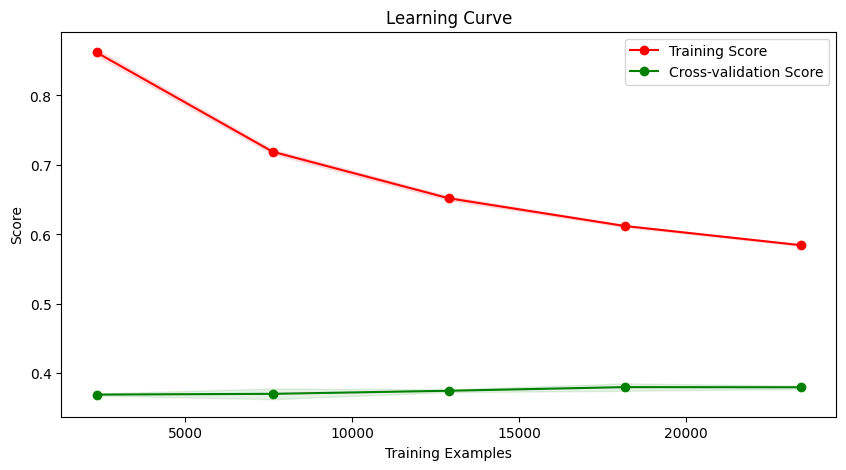

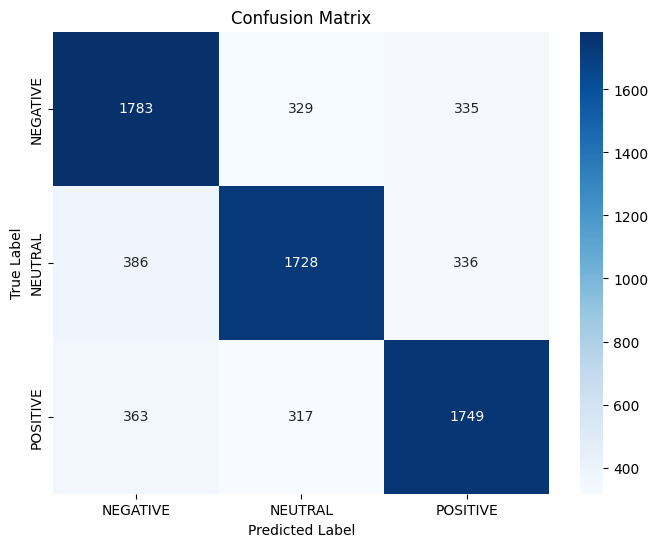

[    1     2     4 ... 36626 36627 36629] [    0     3     8 ... 36611 36622 36628]
Accuracy: 0.3883428883
Classification Report:
               precision    recall  f1-score   support

    NEGATIVE       0.38      0.38      0.38      2449
     NEUTRAL       0.39      0.40      0.39      2431
    POSITIVE       0.40      0.39      0.39      2446

    accuracy                           0.39      7326
   macro avg       0.39      0.39      0.39      7326
weighted avg       0.39      0.39      0.39      7326



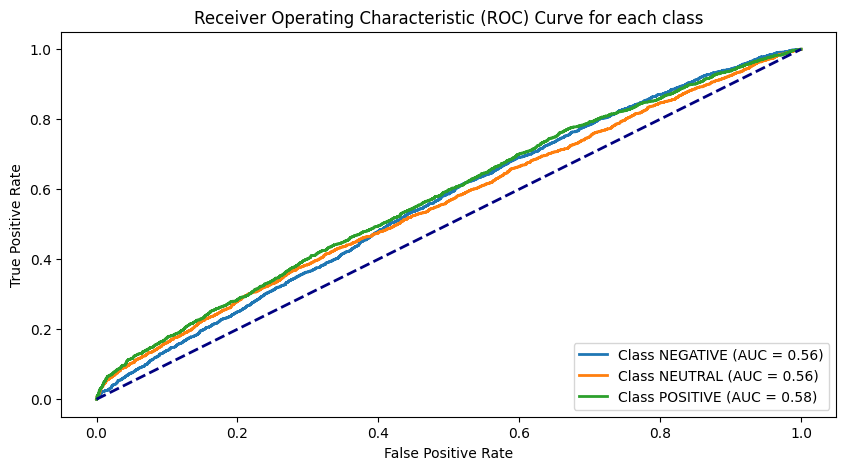

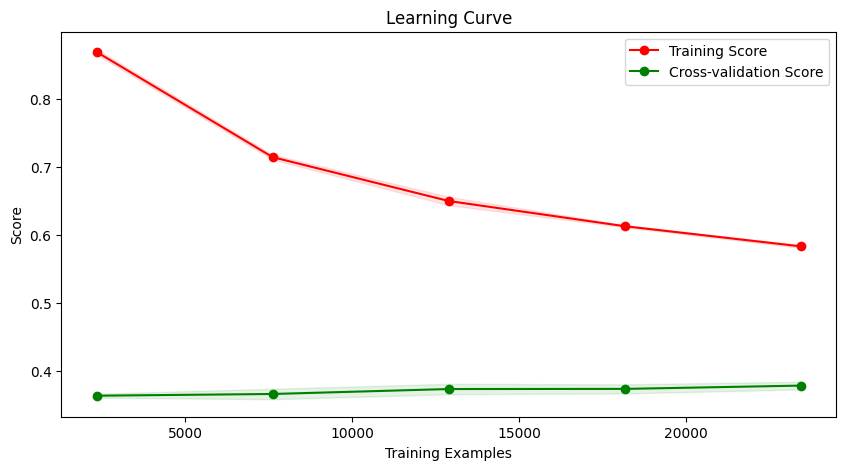

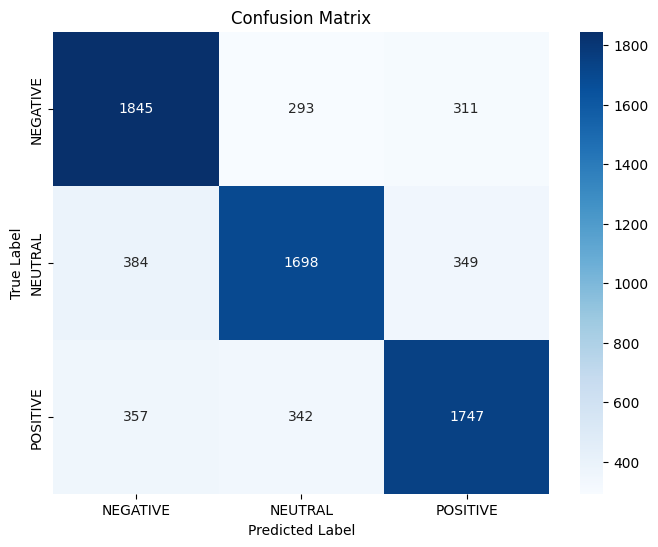

[    0     1     2 ... 36627 36628 36629] [    5    14    19 ... 36619 36625 36626]
Accuracy: 0.3834288834
Classification Report:
               precision    recall  f1-score   support

    NEGATIVE       0.37      0.41      0.38      2367
     NEUTRAL       0.38      0.35      0.37      2474
    POSITIVE       0.40      0.39      0.40      2485

    accuracy                           0.38      7326
   macro avg       0.38      0.38      0.38      7326
weighted avg       0.38      0.38      0.38      7326



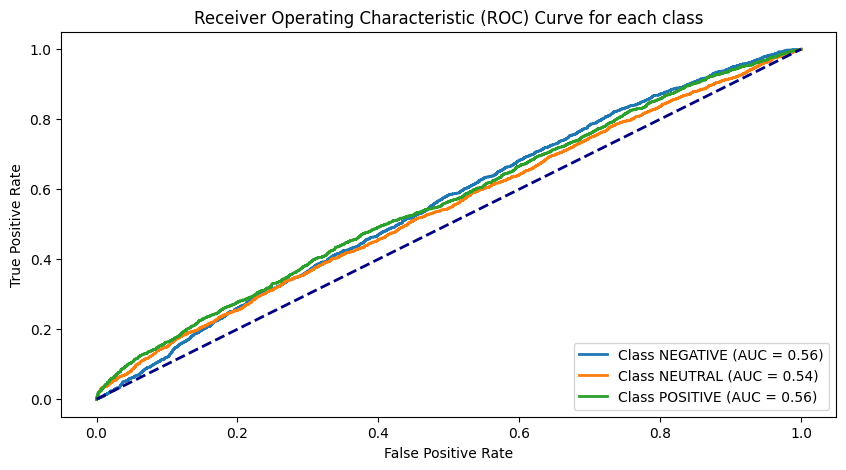

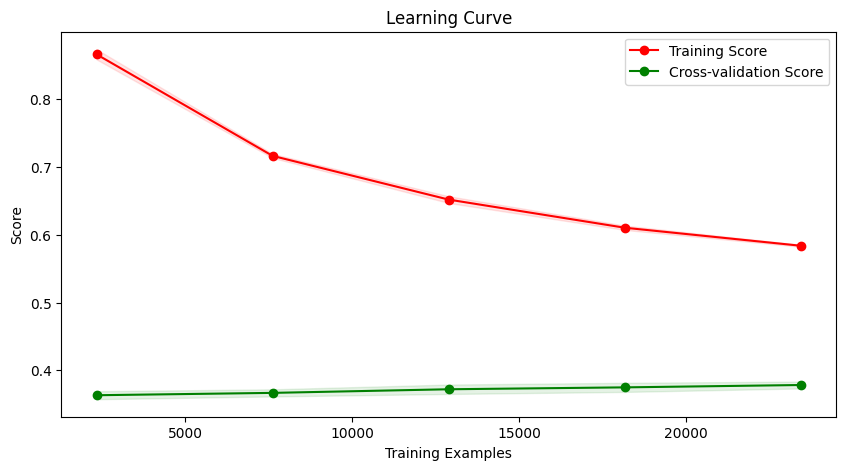

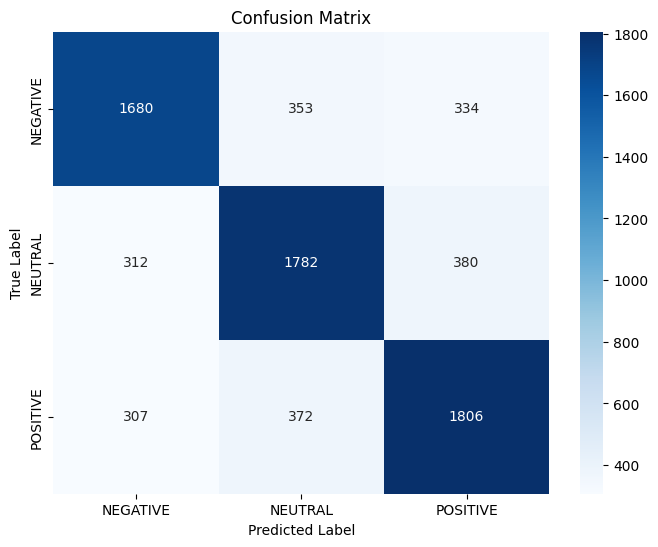

[    0     1     3 ... 36626 36628 36629] [    2    10    11 ... 36621 36623 36627]
Accuracy: 0.3749658750
Classification Report:
               precision    recall  f1-score   support

    NEGATIVE       0.37      0.39      0.38      2483
     NEUTRAL       0.36      0.36      0.36      2434
    POSITIVE       0.39      0.38      0.38      2409

    accuracy                           0.37      7326
   macro avg       0.38      0.37      0.37      7326
weighted avg       0.38      0.37      0.37      7326



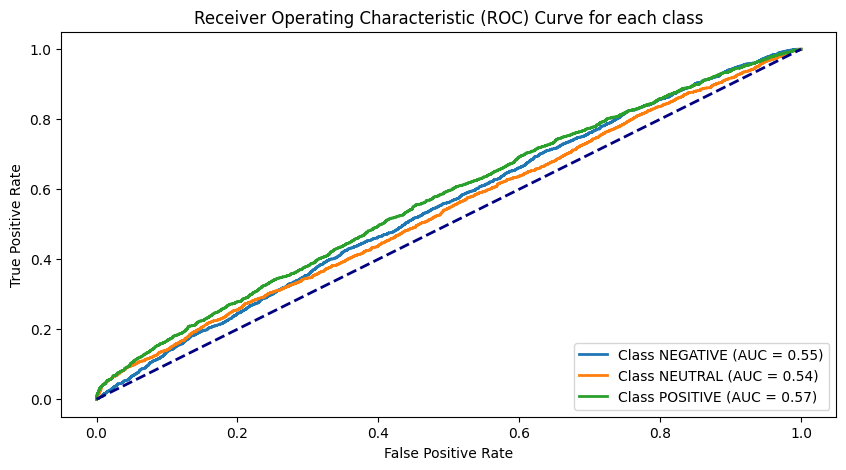

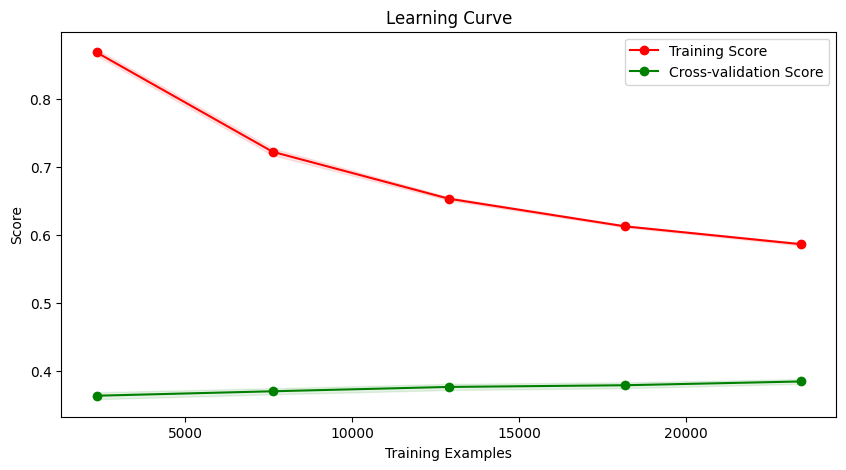

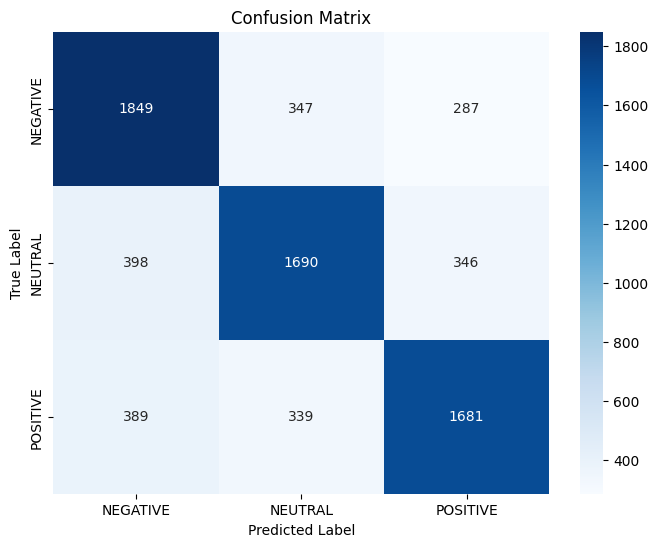

[    0     2     3 ... 36627 36628 36629] [    1     9    16 ... 36613 36615 36618]
Accuracy: 0.3867048867
Classification Report:
               precision    recall  f1-score   support

    NEGATIVE       0.38      0.39      0.39      2464
     NEUTRAL       0.38      0.38      0.38      2421
    POSITIVE       0.39      0.38      0.39      2441

    accuracy                           0.39      7326
   macro avg       0.39      0.39      0.39      7326
weighted avg       0.39      0.39      0.39      7326



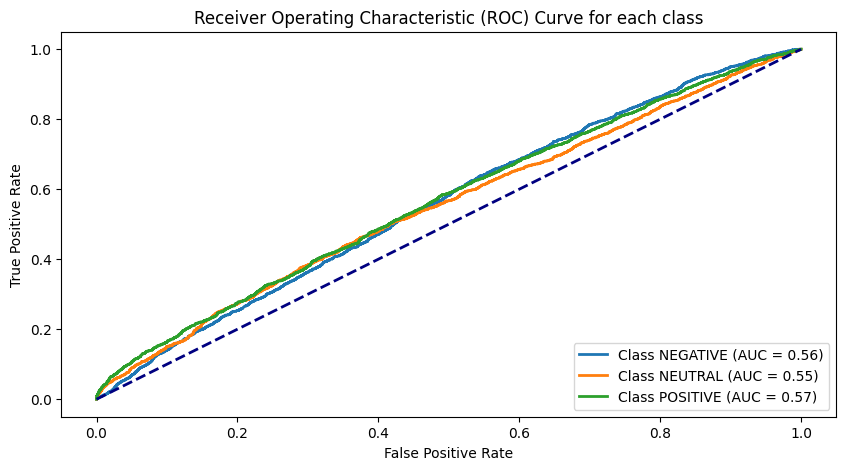

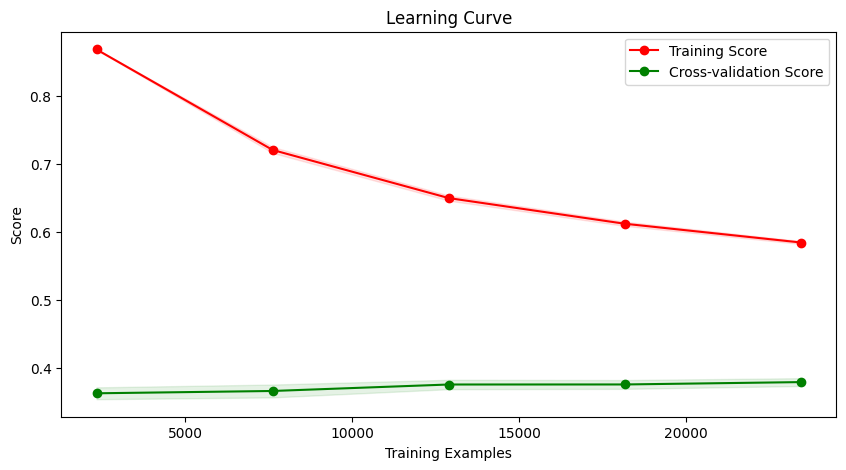

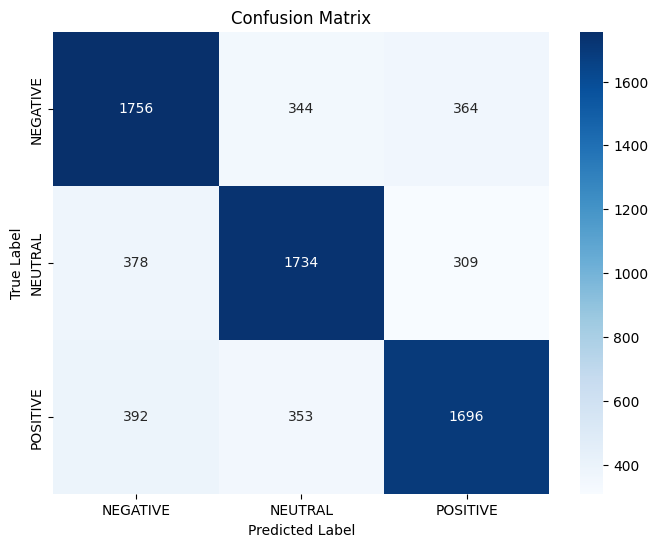

In [17]:
# Kfold for 5 folds
kf = KFold(n_splits=5, shuffle=True, random_state=42)
y_k = df["Sentiment"]

for train_index, test_index in kf.split(line_vectors):
    # Train-Test split
    print (train_index, test_index)
    X_k_train = [line_vectors[i] for i in train_index]
    y_k_train = y_k[train_index]
    X_k_test = [line_vectors[i] for i in test_index]
    y_k_test = y_k[test_index]

    # TF-IDF vectorization
    X_k_train_tfidf = tfidf_vectorizer.fit_transform([' '.join(line) for line in X_k_train])
    X_k_test_tfidf = tfidf_vectorizer.transform([' '.join(line) for line in X_k_test])

    model.fit(X_k_train_tfidf, y_k_train)

    # Prediction and find the accuracy
    y_k_pred = model.predict(X_k_test_tfidf)
    accuracy = accuracy_score(y_k_test, y_k_pred)
    print(f"Accuracy: {accuracy:.10f}")
    print("Classification Report:\n", classification_report(y_k_test, y_k_pred))

    # Plot ROC Curve plot
    plot_roc_curve(model, X_k_train_tfidf, X_k_test_tfidf, y_k_train, y_k_test)

    # Learning Curve plot
    plot_learning_curve(model, X_k_train_tfidf, y_k_train)

    # Confusion Matrix plot
    plot_confusion_matrix(model, X_k_test_tfidf, y_k_test)

In [18]:
# Valid dataset
y_valid = df_valid_csv["Sentiment"]
X_valid_tfidf = tfidf_vectorizer.transform([' '.join(line) for line in line_vectors_valid])

# Prediction and find the accuracy
y_valid_pred = model.predict(X_valid_tfidf)
accuracy = accuracy_score(y_valid, y_valid_pred)
print(f"Accuracy: {accuracy:.10f}")
print("Classification Report:\n", classification_report(y_valid, y_valid_pred))

Accuracy: 0.3824541284
Classification Report:
               precision    recall  f1-score   support

    NEGATIVE       0.37      0.39      0.38      1744
     NEUTRAL       0.38      0.37      0.37      1744
    POSITIVE       0.40      0.38      0.39      1744

    accuracy                           0.38      5232
   macro avg       0.38      0.38      0.38      5232
weighted avg       0.38      0.38      0.38      5232

